# Exercise 3 - HDR reconstruction and camera chracterization

In [1]:
# Imports
import numpy as np
import numpy.matlib
import numpy.random
from matplotlib import pyplot as plt
import matplotlib
from scipy import ndimage
from scipy import misc
from scipy import fftpack
from scipy import optimize
import scipy.io
import skimage
import imageio

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# for 16 bit PNG support in imageio if needed, imageio.plugins.freeimage.download() might need to be run once per system (or exr/hdr/pgm/ppm support)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

In [2]:
# Some useful functions
def applyColorMatrix(values, mat):
    tmp = values.reshape(-1, 3)
    tmp = np.matmul(tmp, mat)
    return np.reshape(tmp, values.shape)

def srgb2linear(x):
    linear = x.copy()
    less = linear <= 0.0404482362771082
    linear[less] = linear[less] / 12.92
    linear[~less] = np.power((linear[~less] + 0.055) / 1.055, 2.4)
    return linear

    
def linear2srgb(x):
    srgb = x.copy()
    less = x <= 0.0031308
    srgb[less] = x[less] * 12.92
    srgb[~less] = 1.055 * np.power(x[~less], 1.0 / 2.4) - 0.055
    return srgb

# 3.1 HDR reconstruction

In a camera light enters the lens and illuminates the sensor. This illuminance has a linear relationship to the radiance of the scene. The illuminance has a linear relationship to the integration time, it is proportional to the square of the f-stop and reciprocal to the square of the focal length.

In [3]:
# Because cameras have a limited dynamic range multiple exposures with different integration times are needed to measure the full dynamic range of most natural scenes. 
# Why is it preferred to change the exposure time over changing the f-stop for the different exposures when acquiring HDR Stacks?

# Verschiedene Blenden beeinflussen die Tiefenschärfe im Bild.
# Würde man Bilder mit unterschiedlichen Blenden zusammenfügen hätte man je nach Helligkeit des Bildinhalts einen anderen Tiefenschärfeneindruck.
# Nachteil hiervon: Das Motiv sollte sich gerade bei den sehr langen Belichtungszeiten nicht bewegen.

# First load the demosaiced rgb images from the last exercise
rgbImg = np.load('../Ex_2/rgb_exposure_stack.npmat.npy')

In [4]:
# To illustrate how much data we have in memory:
print('Image shape:', rgbImg.shape)
print('Memory consumption:', np.prod( rgbImg.shape ) * 8 / 1024 / 1024, 'MB')

Image shape: (2591, 1722, 3, 7)
Memory consumption: 714.8417816162109 MB


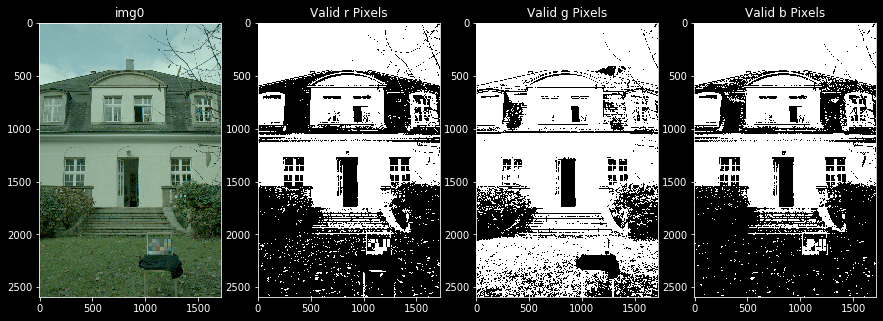

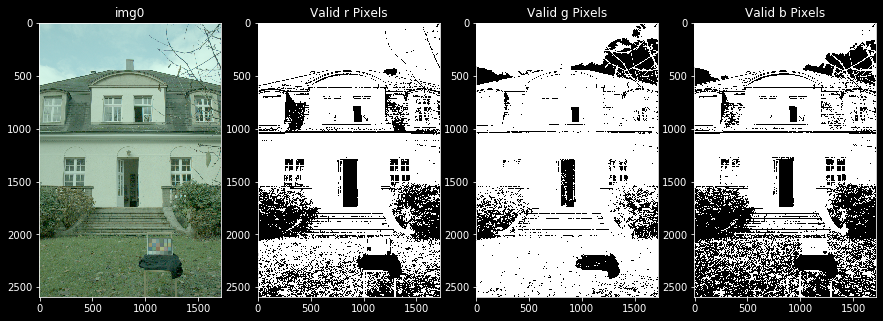

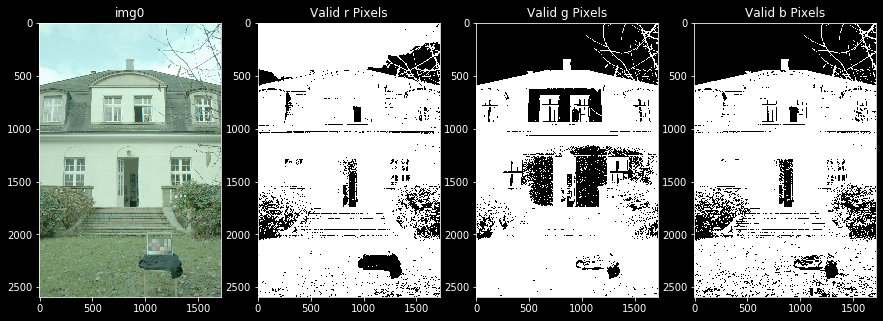

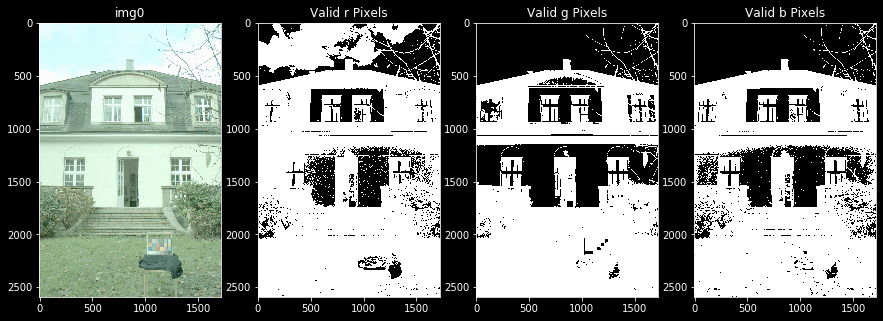

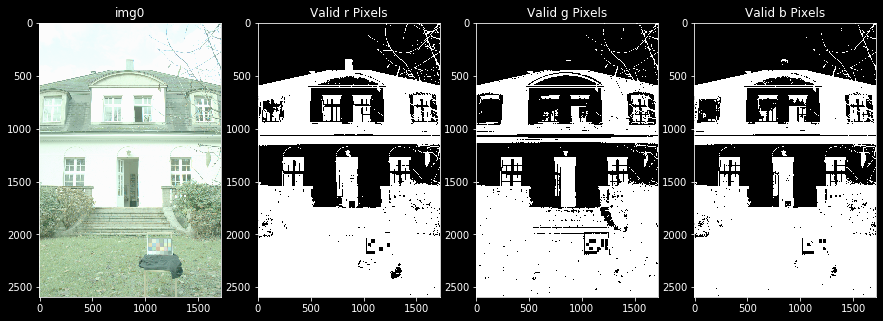

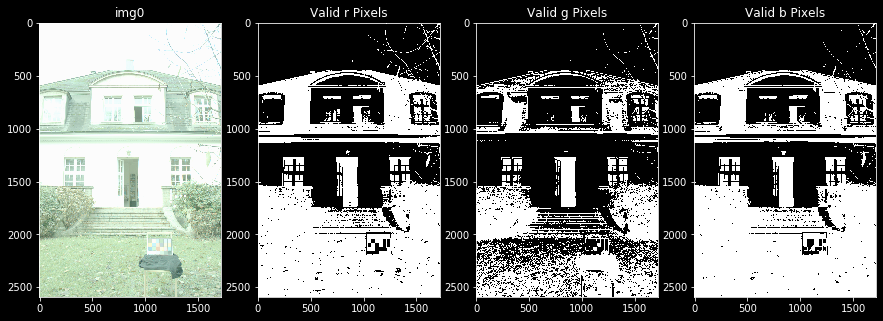

In [7]:
# Now estimate the exposure time for Haus_02.tiff to Haus_07.tiff relative to Haus_01.tiff by finding the factor that minimizes the sum of squared differences between both images and by dividing the relavant pixels of each picture to its neighbouring image and calculating the mean and median of all these fractions.
# Hint: Make sure you exclude the noisy and clipped pixels for both images to get the correct result. 

# Define a range of valid luminances:
highCut = 0.9  # Ignore the highest 10% beacuse lots of cameras do weird stuff there
lowCut  = 0.01 # Limit to the top 6 stops because it gets noisy below 6 stops under peak white

# We will try 3 methods: Least square optimization, median and mean
ev_ls     = np.zeros(6)
ev_median = np.zeros(6)
ev_mean   = np.zeros(6)

for i in range(6):
    # This is the base image (Use only a small fraction of pixels for debugging)
    img0 = rgbImg[:,:,:, i]

    # This is the next image (Use only a small fraction of pixels for debugging)
    img1 = rgbImg[:,:,:, i+1]

    # Build a mask that only includes those pixel that are within LowCut and HighCut for both images
    pix_mask = (img0 < highCut) * (img0 > lowCut) * (img1 < highCut) * (img1 > lowCut)
    # pix_mask besteht aus einem Array aus True (1) und False (0). Sobald ein Filter False auswertet 
    # entsteht an dieser Stelle eine 0. Sie bleibt auch bei weiteren Multiplikationen eine 0 
    # und alle 4 Filterabfragen werden zusammengefügt.

    # Show what is used from the current images
    plt.style.use('dark_background')
    fig,a =  plt.subplots(1, 4)
    a[0].imshow( ( np.log2( np.fmax( 2**-10, np.fmin( 1.0, img0 ) ) ) + 10 ) / 10, cmap='gray', vmin=0, vmax=1)
    a[0].set_title("img0")
    a[1].imshow( pix_mask[:,:,0] * 1.0, cmap='gray', vmin=0, vmax=1)
    a[1].set_title("Valid r Pixels")
    a[2].imshow( pix_mask[:,:,1] * 1.0, cmap='gray', vmin=0, vmax=1)
    a[2].set_title("Valid g Pixels")
    a[3].imshow( pix_mask[:,:,2] * 1.0, cmap='gray', vmin=0, vmax=1)
    a[3].set_title("Valid b Pixels")

    

In [23]:
for i in range(6):
    img0 = rgbImg[:,:,:, i]
    img1 = rgbImg[:,:,:, i+1]
    pix_mask = (img0 < highCut) * (img0 > lowCut) * (img1 < highCut) * (img1 > lowCut)
    
    # Define a function for minimization ( least squares needs the squared difference as cost function ):
    def minFun(x):
        return sum(sum(sum((img0 - x * img1) ** 2 * pix_mask)))
        # sum(sum(sum(array))) reduziert dreidimensionales array auf eine Zahl.
    
    # Use optimization: Unfortunately "optimize.fmin" is quite slow
    ev_ls[i]     = optimize.fmin( func=minFun, x0=[1.0], disp=False)[0]    

    # Calculate the median of the valid pixels of img0 divided by img1
    ev_median[i] = np.median(img0 * pix_mask)/np.median(img1 * pix_mask)

    # Calculate the mean of the valid pixels of img0 divided by img1
    ev_mean[i]   = np.mean(img0 * pix_mask)/np.mean(img1 * pix_mask)

print('LeastSquare', ev_ls)
print('Medians    ', ev_median)
print('Means      ', ev_mean)

# Erkenntnis: jedes Bild wurde doppelt so lange belichted wie der Vorgänger.

# Which method do you prefer in terms of speed of execution and precision of the result?
# Stoppuhr: Least Square 00:02:23
# Stoppuhr: Medians      00:00:09
# Stoppuhr: Least Square 00:00:06
# LeastSquare Fehler: 0.0064331054687501625
# Median      Fehler: 0.004750169708061858
# Means       Fehler: 0.0058064802899684504

# timeit hätte zu lang gedauert (aufgrund der Anzahl der Versuche)

# Die Median Funktion ergibt den kleinsten Fehler und sie ist deutlich schneller als die LeastSquare Funktion.
# Mean wäre noch etwas schneller, aber auch der Fehler ist etwas größer.

Means       [0.50533026 0.4890907  0.48883185 0.5038868  0.50022818 0.49668381]


In [25]:
#Differenzen:
print("LeastSquare Fehler: " + str(np.sum(np.abs(0.5 - ev_ls))/6))
print("Median      Fehler: " + str(np.sum(np.abs(0.5 - ev_median[0:4]))/5)) # woher kommt nan Fehler, Kurt?
print("Means       Fehler: " + str(np.sum(np.abs(0.5 - ev_mean))/6))

LeastSquare Fehler: 0.0064331054687501625
Median      Fehler: 0.004750169708061858
Means       Fehler: 0.0058064802899684504


In [24]:
# Now let's reconstruct the original radiance of the scene from the image stack. 
# Weight the luminance values by a weight-function that gives more credible values a higher value and completely discards noisy or clipped values. 

# First write a hat funtion for weighting
def hatFun(x, l, m, h):
     result = np.zeros(x.shape)
     result[ x <= l    ] = x[ x <= l    ] * 0
     result[ l < x <= m] = x[ l < x <= m] * 1/(m-l)-(l*1/(m-l))
     result[ m < x <= h] = x[ m < x <= h] * 1/(h-m)-(m*1/(h-m))
     result[ h < x     ] = x[ h < x     ] * 0
     return result

In [25]:
# Verify the hat function (also for values out of range 0...1)
fig, ax = plt.subplots( figsize=(15,7) )

x = np.linspace(-0.1, 1.1, 1000)
plt.plot( x, hatFun(x, 0.1, 0.4, 0.78 ) );
plt.grid( linestyle=':' )

# Reference how it schould look like:
newax = fig.add_axes( [0.59, 0.56, 0.3, 0.3], anchor='NE', zorder=1 )
newax.imshow( plt.imread('additional/hat_fun_plot.png') / 0.8 + 0.1, interpolation = 'catrom' );
newax.axis('off')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Calculate Weights for each pixel in each color and stack image. 
# Make sure to capture all pixels even if they are not within the hat function in any picture
hdrWeights = # Your code here
# Your code here
# Your code here

In [ ]:
# Calculate the absolute exposure correction from the realtive exposure differences 'ev_median'
evCorrection = # Your code here

In [ ]:
# Reconstuct an HDR image from the exposure stack by combining the image according to the weights.
# Don’t forget to normalize the result for each color channel and pixel by the sum of your weights to get the correct result.
hdrImg = # Your code here
hdrImg[np.isnan(hdrImg)] = 0.0  # a few pixels might be nan. If no correct weight was found

In [ ]:
# Lets verify the shadows. Your reconstruction should be as clean as in the lowlight preserving exposure
plt.style.use('dark_background')
plt.subplot(1,3,1)
plt.imshow(lin2srgb(rgbImg[1000:2500,600:1500,:,0] / np.prod(ev_median)))
plt.title('Noisy shadows in the\nhighlight Preserving Exposure')

plt.subplot(1,3,2)
plt.style.use('dark_background')
plt.imshow(lin2srgb(rgbImg[1000:2500,600:1500,:,6]))
plt.title('Clean shadows in the\nlowlight preserving exposure')

plt.subplot(1,3,3)
plt.style.use('dark_background')
plt.imshow(lin2srgb(hdrImg[1000:2500,600:1500,:] / np.prod(ev_median)))
plt.title('Clean shadows in the\nHDR reconstruction')

plt.figure()
plt.imshow( plt.imread('additional/Source_vs_Reconstruction_1.png'), interpolation = 'catrom' );
plt.title('This is how your result should look like')

In [ ]:
# Lets verify the highlights. Your reconstruction should be as unclipped as the highlight preserving exposure
plt.style.use('dark_background')
plt.subplot(1,3,1)
plt.imshow(lin2srgb(rgbImg[:,:,:,0]))
plt.title('Sky looks fine in the\nhighlight preserving exposure')
plt.subplot(1,3,2)
plt.imshow(lin2srgb(rgbImg[:,:,:,6] * np.prod( ev_median )))
plt.title('Sky is completely clipped\nin the lowlight preserving exposure')
plt.subplot(1,3,3)
plt.imshow(lin2srgb(hdrImg))
plt.title('All details there in the\nHDR reconstruction')

plt.figure()
plt.imshow( plt.imread('additional/Source_vs_Reconstruction_2.png'), interpolation = 'catrom' );
plt.title('This is how your result should look like')
# Where do the  color artifacts around the clouds in the sky come from? How could they be avoided?
#
#
#
# Bonus points: Shoot your own exposure stack and process it using this script. Make sure you dont touch your camerera between exposures, e.g. use an app to control your camera. Frank (Pool) has Color Checkers for rent. the color checker needs to be fully hoizontal and vertically aligned with the image orientation. You will find out why in the next part of this exercise.
#
#
#

# 3.2 Camera characterization

Looking at the image from exercise 3.1 it can be seen that the colors are not displayed faithfully. We will use three different methods that we learned in the lecture to adjust the colors from the native color space of the 5DMkII to sRGB.

In [ ]:
# These are ther reference Color Checker Values from Babelcolor
cc_ref = np.array([[115, 82, 68], [195, 149, 128], [93, 123, 157], [91, 108, 65], [130, 129, 175], [99, 191, 171], [220, 123, 46], [72, 92, 168], [194, 84, 97], [91, 59, 104], [161, 189, 62], [229, 161, 40], [42, 63, 147], [72, 149, 72], [175, 50, 57], [238, 200, 22], [188, 84, 150], [0, 137, 166], [245, 245, 240], [201, 202, 201], [161, 162, 162], [120, 121, 121], [83, 85, 85], [50, 50, 51]], dtype=np.float)

# Convert these reference values from 8 bit sRGB to scene linear
cc_ref = srgb2lin(cc_ref / 255.0)  #R cc_ref = # Your code here

In [ ]:
# Position values/vsize/hsize multiplied by two to reflect position difference from MATLAB (half debayer) to bilinear debayer

def getCheckerValuesFromHausImage(img, no_checker=False):
    """
    Helper function to extract the color checker patches median values for all 24 color patches of the MacBeth chart
    """
    crop_values = np.concatenate(( np.ones((1,6)) * 2053,
                                   np.ones((1,6)) * 2090,
                                   np.ones((1,6)) * 2127,
                                   np.ones((1,6)) * 2163), axis=1) 
    crop_values = np.concatenate(( crop_values,
                                   np.array([1046, 1081, 1117, 1154, 1190, 1227,   1046, 1081, 1118, 1155, 1191, 1228, 1046, 1081, 1118, 1155, 1191, 1228,   1046, 1081, 1118, 1155, 1191, 1228])[:,None].T  - 1.5), axis=0) - 5
    crop_values = np.uint32(crop_values)

    vsize = 26
    hsize = 26 

    cc_values = np.zeros((24, 3))

    select = np.zeros((img.shape[0], img.shape[1]), dtype=int)

    for i in range(24):
        # using nanmedian in case we somehow have an invalid pixel value (nanmedian ignores nan-values)
        tmp = np.nanmedian(img[crop_values[0, i]:crop_values[0, i]+hsize, crop_values[1, i]:crop_values[1, i]+vsize, :], axis=0)
        cc_values[i, :] = np.nanmedian(tmp, axis=0)
        select[crop_values[0, i]:crop_values[0, i]+hsize, crop_values[1, i]:crop_values[1, i]+vsize] = 1

    if not no_checker:
        errosion_structure = ndimage.generate_binary_structure(2, 1)
        select = select - ndimage.grey_erosion(select, size=(3,3), footprint=errosion_structure)
        
        tmp_img = img / np.max(img) + select[:,:,None]
        tmp_img = tmp_img[2030:2210, 1010:1290,:]
        plt.imshow(lin2srgb(tmp_img / np.max(tmp_img)))
        plt.show()

    return cc_values

In [ ]:
# To remove the green cast from the image one could scale all three color channels so that the white patch of the color checker ( 19th Patch ) results in the target values from Babelcolor converted to linear. Use the supplied function Exercise_04_getCheckerValuesFromHausImage.m to extract the color checker values from your image. 

# Exttract the actual values from the color checker
cc_vals = getCheckerValuesFromHausImage(hdrImg)

plt.figure()
plt.imshow( plt.imread('additional/cc_select.png'), interpolation = 'catrom' );
plt.title('This is how your result should look like')

cc_vals.shape


In [ ]:
# Now Scale the three color channels accordingly and display the image. 

# * Hint 1: It is common to have diffuse white at 1.0 in linear light images. One stop below white is at 0.5, two stops below white at 0.25 and typical Caucasian skin tones at 0.18. Specular highlights and light sources can be way above 1.0.

imgCCbyScaling = np.zeros(hdrImg.shape)

for i in range(3):
    imgCCbyScaling[:,:,i] = hdrImg[:,:,i] # Your code here

plt.imshow( lin2srgb( imgCCbyScaling ) )

plt.figure()
plt.imshow( plt.imread('additional/Result_RGB_Scaling.png'), interpolation = 'catrom' );
plt.title('This is how your result should look like')

# You have solved one problem, but which problem persists?
#
#
#

### 3.2.2 Direct inverse

In [ ]:
# The second approach to camera characterization that you learned in the lecture is the direct inverse. Calculate the matrix that results in the correct color values for the red, green and blue patch.

# Get the source values again
cc_vals = getCheckerValuesFromHausImage(hdrImg, no_checker=True)

# Calculate the direct inverse. Yes, this is only one line, but it may take an hour of remebering matrix algebra
direct_inverse = # Your code here. Direct inverse shoud be a 3*3 matrix.

img_di = applyColorMatrix( hdrImg, direct_inverse )

plt.imshow( lin2srgb( img_di ) )

plt.figure()
plt.imshow( plt.imread('additional/Result_Direct_Inverse.png'), interpolation = 'catrom' );
plt.title('This is how your result should look like')

# What do you like about this method? What could be improved?

In [ ]:
# Now calculate the pseudoinverse using all 24 patches in linear RGB domain. If you are unsure how to find the matrix that minimizes the squared error for all 24 patches search for ‘linear least squares’ or ‘normal equation’. You may also want to watch this graphical explanation of the least squares pseudo inverse: https://www.youtube.com/watch?v=Z0wELiinNVQ&nohtml5=False. (0:00 – 8:40)

# Apply the matrix you calculated to your reconstructed image. 

cc_vals = getCheckerValuesFromHausImage(hdrImg, no_checker=True)

pseudo_inverse = # Your code here. Direct inverse shoud be a 3*3 matrix.
img_pi = applyColorMatrix( hdrImg, pseudo_inverse )

plt.imshow(lin2srgb(img_pi))

plt.figure()
plt.imshow( plt.imread('additional/Result_Pseudo_Inverse.png'), interpolation = 'catrom' );
plt.title('This is how your result should look like')

# Compare the colors to both methods before. Which method do you prefer and why?
#
#

# In which domain would an actual color scientist minimize the squared error for the pseudo inverse matrix? What Python function would you use for this?
#
#
#

In [ ]:
# Save for later use!
np.save('hdr_image_pinv', img_pi)